In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmc
import cartopy.crs as ccrs
import os
from cartopy import geodesic as cgeod
from geopy.distance import geodesic 
from tqdm import tqdm
import warnings
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, Normalize
from multiprocess import Pool
import cartopy.feature as cfeature
import scipy.stats as stats
from glob import glob
## my own directory
os.chdir("/g/data/k10/dl6968/Semi-variogram_AU/")


In [2]:
from gstools import CovModel

class Stab(CovModel):
    def variogram(self, r):
        
        return self.nugget + self.sill * (1 - np.exp(-(3 * r) / self.len_scale))

In [3]:
params={     
    'axes.labelsize'  : '16',   
    'axes.titlesize'  : '16',  
    'xtick.labelsize' :'16',
    'ytick.labelsize' :'16',    
    'lines.linewidth' : '2' ,   
    'legend.fontsize' : '12', 
    'figure.figsize'   : '12, 7'    
}
plt.rcParams.update(params)

In [4]:
df = pd.read_csv("./data/BoM_daily_stations.csv")
exclude_stn = []
for stn_id in df["ID"]:
    bom_id = str(stn_id).zfill(6)
    if not os.path.exists(f'./data/all_AU_p90_1960/{stn_id}_pair_scale_moving_list_all_events.csv'):
        exclude_stn.append(stn_id)
## mannually remove some faulty stations
df = df[~df["ID"].isin(exclude_stn)]

In [5]:
# Define seasons based on month
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return "DJF"
    elif month in [3, 4, 5]:
        return "MAM"
    elif month in [6, 7, 8]:
        return "JJA"
    elif month in [9, 10, 11]:
        return "SON"

# Method: weighted bins

In [6]:
bin_files = sorted(glob("./data/all_AU_p90_1960/*_pair_bins_moving_list_all_events.csv"))
fit_model = Stab(dim=2)  # Choose model type (Exponential, Spherical, Gaussian, etc.)

# Function to compute weighted mean of gamma for each bin
def weighted_mean_gamma(x):
    if np.sum(x["Norm_Weight"]) > 0:
        return np.sum(x["gamma"] * x["Norm_Weight"]) / np.sum(x["Norm_Weight"])
    else: 
        return 0
def bins_to_season(file):
    
    df_bins = pd.read_csv(file, usecols=lambda col: not col.startswith("Unnamed")) 
    df_bins["Date"] = pd.to_datetime(df_bins["Date"])
    df_bins["Season"] = df_bins["Date"].apply(get_season)
    df_bins["Tot"] = df_bins["N11"] + df_bins["N10"]
    mean_stations_per_bin = df_bins.groupby(["Season", "Bins"])["Tot"].transform("mean")
    df_bins["Raw_Weight"] = df_bins["Tot"] / mean_stations_per_bin
    ## normalise weight
    df_bins["Norm_Weight"] = df_bins.groupby(["Season", "Bins"])["Raw_Weight"].transform(lambda x: x / x.sum())
    
    
    # Apply the weighted mean function per Season & Bin
    ivw_gamma = df_bins.groupby(["Season", "Bins"]).apply(weighted_mean_gamma).reset_index(name="IVW_Gamma")
    bins_yfit_dict = {}
    bins_scale_dict = {}
    for seasons in ["DJF", "MAM", "JJA", "SON"]:
        bins = ivw_gamma[ivw_gamma["Season"]==seasons]["Bins"].values
        gamma = ivw_gamma[ivw_gamma["Season"]==seasons]["IVW_Gamma"].values
        if len(gamma)==0:
            bins = np.arange(1,720,20)
            y_fit = np.zeros_like(bins)
            gamma = np.zeros_like(bins)
            scale = 0
            
        else:
            try:
                _ = fit_model.fit_variogram(bins, gamma, sill=0.5-0.025, nugget=0.025)
                y_fit = fit_model.variogram(bins)
                scale = fit_model.len_scale
            except RuntimeError:
                y_fit = np.zeros_like(bins)
                scale = 0
        bins_yfit_dict[seasons+"_yfit"] = y_fit
        bins_yfit_dict[seasons+"_gamma"] = gamma    
        bins_scale_dict[seasons] = scale
    bins_yfit_dict["Bins"] = bins
    df_season_bins = pd.DataFrame.from_dict(bins_yfit_dict)
    df_season_bins.to_csv(file.replace("pair", "season"))
    df_season_scale = pd.DataFrame.from_dict(bins_scale_dict, orient="index", columns=["scale"])
    df_season_scale.to_csv(file.replace("pair_bins", "season_scale"))

In [7]:
max_pool = 24
with Pool(max_pool) as p:
    pool_outputs = list(tqdm(
            p.imap(bins_to_season,
                   bin_files),
        total=len(bin_files),
        position=0, leave=True,  desc="Processing seasonality",
    )
    )
p.join()

Processing seasonality: 100%|██████████| 2165/2165 [00:30<00:00, 71.19it/s]


In [9]:
season_weight_dict = {"DJF":[], "MAM":[], "JJA":[], "SON":[]}
for spec_id in tqdm(df["ID"],leave=True, position=0):
    df_scale = pd.read_csv(f"./data/all_AU_p90_1960/{spec_id}_season_scale_moving_list_all_events.csv",index_col=0)
    for seasons in ["DJF", "MAM", "JJA", "SON"]:
        season_weight_dict[seasons].append( df_scale.loc[seasons].values)

100%|██████████| 2165/2165 [00:04<00:00, 434.10it/s]


(-45.0, -9.0)

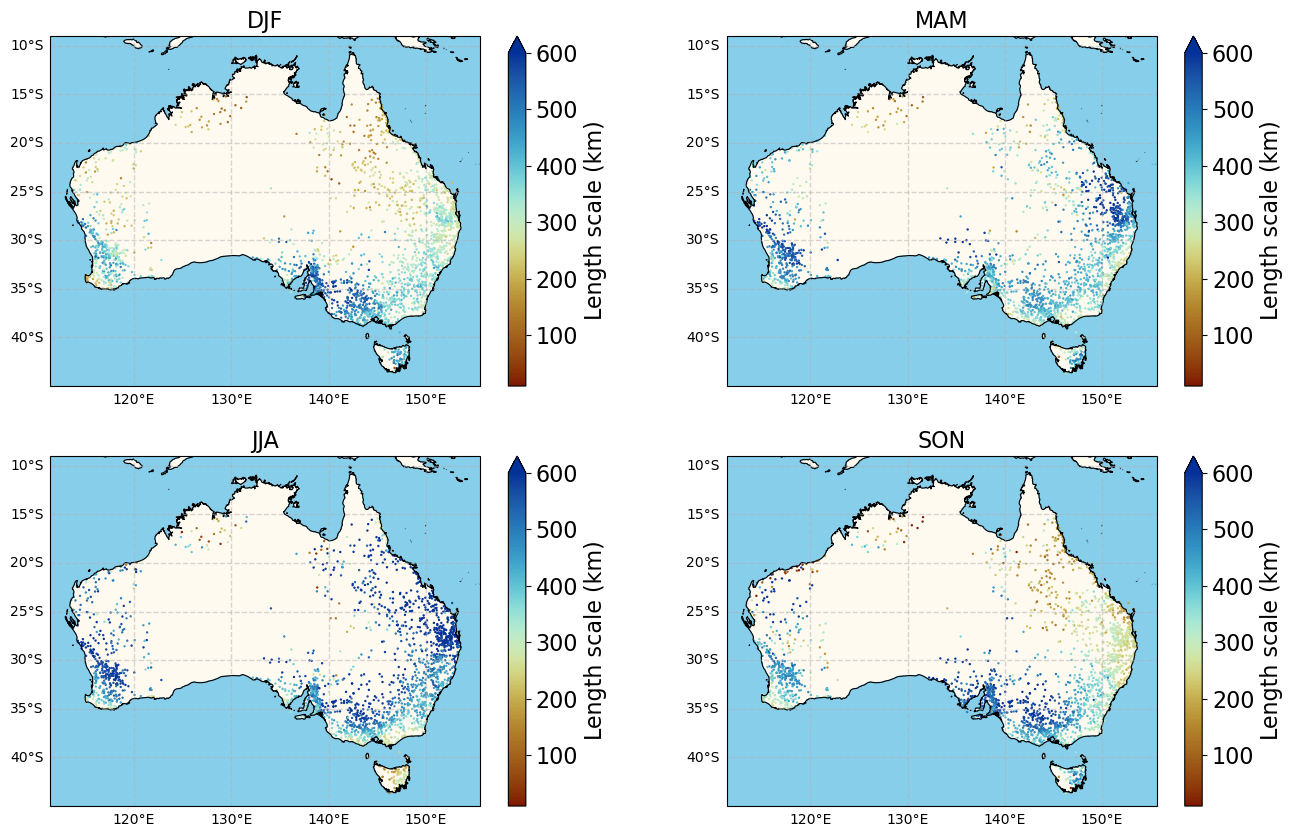

In [11]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(221, projection=ccrs.PlateCarree())
cmap = "cmc.roma"
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= season_weight_dict["DJF"], cmap=cmap, vmin=10,vmax=600, 
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax1.coastlines('10m', color="black",linewidth=0.8)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax1.set_title("DJF")
ax1.add_feature(cfeature.LAND, color='floralwhite')  
ax1.add_feature(cfeature.OCEAN, color='skyblue')  
ax1.set_ylim([-45,-9])

ax2 = fig.add_subplot(222, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= season_weight_dict["MAM"], cmap=cmap, vmin=10,vmax=600, 
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax2.coastlines('10m', color="black",linewidth=0.8)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax2.set_title("MAM")
ax2.add_feature(cfeature.LAND, color='floralwhite')  
ax2.add_feature(cfeature.OCEAN, color='skyblue')  
ax2.set_ylim([-45,-9])

ax3 = fig.add_subplot(223, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= season_weight_dict["JJA"], cmap=cmap, vmin=10,vmax=600,
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax3.coastlines('10m', color="black",linewidth=0.8)
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax3.set_title("JJA")
ax3.add_feature(cfeature.LAND, color='floralwhite')  
ax3.add_feature(cfeature.OCEAN, color='skyblue')  
ax3.set_ylim([-45,-9])

ax4 = fig.add_subplot(224, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= season_weight_dict["SON"],  cmap=cmap, vmin=10,vmax=600,  
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax4.coastlines('10m', color="black",linewidth=0.8)
gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax4.set_title("SON")
ax4.add_feature(cfeature.LAND, color='floralwhite')  
ax4.add_feature(cfeature.OCEAN, color='skyblue')  
ax4.set_ylim([-45,-9])
# plt.savefig("AU_seasonality.png", dpi=200, bbox_inches="tight")

## Method 1.1: just calculate the means

In [12]:
season_dict = {}
for spec_id in tqdm(df["ID"],leave=True, position=0):
    df_scale = pd.read_csv(f"./data/all_AU_p90_1960/{spec_id}_pair_scale_moving_list_all_events.csv", usecols=lambda col: not col.startswith("Unnamed"))
    df_scale["Date"] = pd.to_datetime(df_scale["extreme_dates"])
    df_scale["Season"] = df_scale["Date"].apply(get_season)
    df_scale["scale"] = df_scale["scale"].replace(0, np.nan)

    seasons = {season: group["scale"].tolist() for season, group in df_scale.groupby("Season")}
    season_dict[str(spec_id)] = seasons

100%|██████████| 2165/2165 [00:54<00:00, 39.38it/s]


In [18]:
djf_mean = [np.nanmedian(season_dict[str(spec_id)]["DJF"]) if "DJF" in season_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]
mam_mean = [np.nanmedian(season_dict[str(spec_id)]["MAM"]) if "MAM" in season_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]
jja_mean = [np.nanmedian(season_dict[str(spec_id)]["JJA"]) if "JJA" in season_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]
son_mean = [np.nanmedian(season_dict[str(spec_id)]["SON"]) if "SON" in season_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]


/jobfs/136843912.gadi-pbs/ipykernel_3676834/1563790501.py:4: RuntimeWarning: All-NaN slice encountered
  son_mean = [np.nanmedian(season_dict[str(spec_id)]["SON"]) if "SON" in season_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]


In [14]:
# Define color segments
colors = [
    (0, "brown"),    
    (0.3, "gold"), 
    (0.7, "lightblue"),
    (1, "royalblue")      
]

# Create custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)


(-45.0, -9.0)

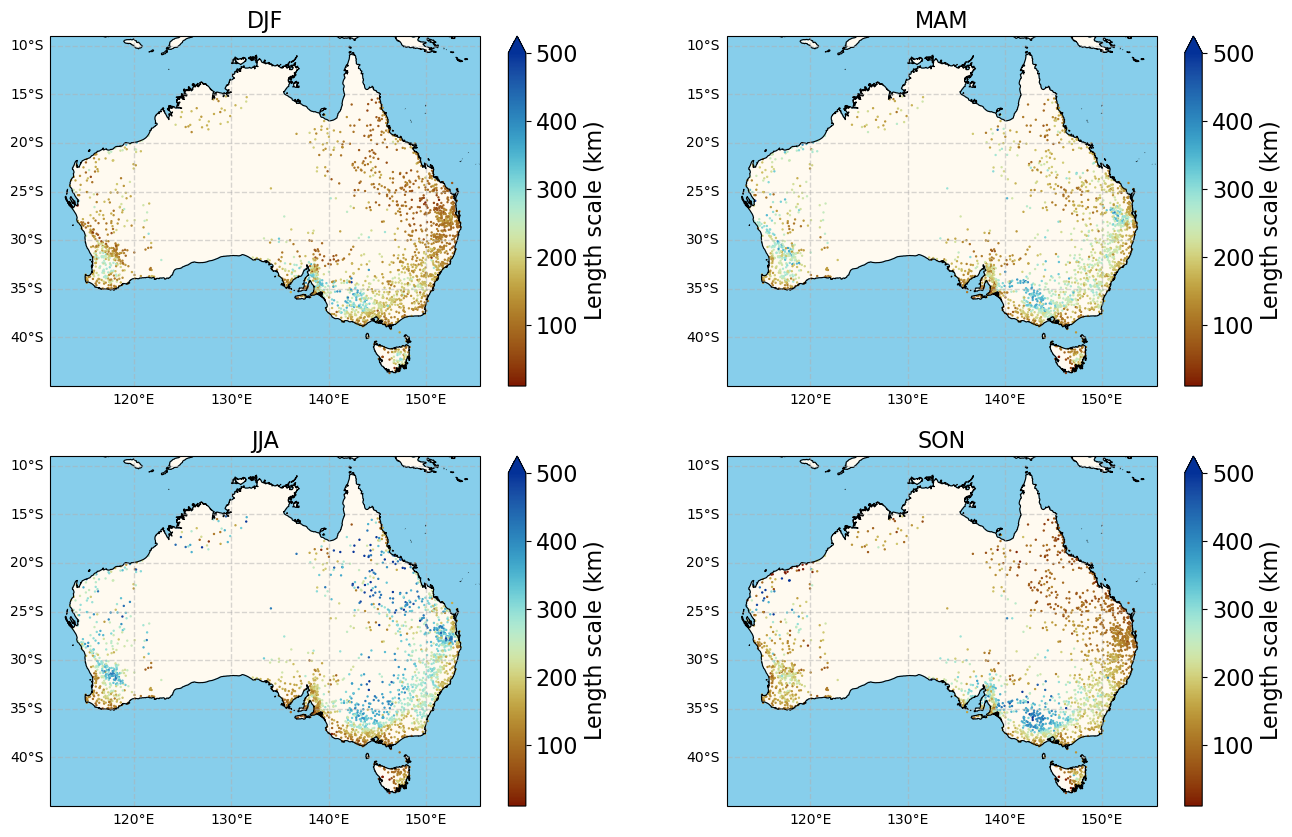

In [19]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(221, projection=ccrs.PlateCarree())
cmap = "cmc.roma"
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= djf_mean, cmap=cmap, vmin=10,vmax=500, 
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax1.coastlines('10m', color="black",linewidth=0.8)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax1.set_title("DJF")
ax1.add_feature(cfeature.LAND, color='floralwhite')  
ax1.add_feature(cfeature.OCEAN, color='skyblue')  
ax1.set_ylim([-45,-9])

ax2 = fig.add_subplot(222, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= mam_mean, cmap=cmap, vmin=10,vmax=500, 
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax2.coastlines('10m', color="black",linewidth=0.8)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax2.set_title("MAM")
ax2.add_feature(cfeature.LAND, color='floralwhite')  
ax2.add_feature(cfeature.OCEAN, color='skyblue')  
ax2.set_ylim([-45,-9])

ax3 = fig.add_subplot(223, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= jja_mean, cmap=cmap, vmin=10,vmax=500,
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax3.coastlines('10m', color="black",linewidth=0.8)
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax3.set_title("JJA")
ax3.add_feature(cfeature.LAND, color='floralwhite')  
ax3.add_feature(cfeature.OCEAN, color='skyblue')  
ax3.set_ylim([-45,-9])

ax4 = fig.add_subplot(224, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= son_mean,  cmap=cmap, vmin=10,vmax=500,  
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax4.coastlines('10m', color="black",linewidth=0.8)
gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax4.set_title("SON")
ax4.add_feature(cfeature.LAND, color='floralwhite')  
ax4.add_feature(cfeature.OCEAN, color='skyblue')  
ax4.set_ylim([-45,-9])
# plt.savefig("AU_seasonality.png", dpi=200, bbox_inches="tight")

# NRM regions

In [20]:
# Load the shapefile of regions
regions_gdf = gpd.read_file("/g/data/k10/dl6968/Rain_gauge_scale/data/NRM_modified/NRM_modified.shp") 

In [21]:
## this is for length scale
def nrm_length(id_df):
    djf_mean = np.array([np.nanmean(season_dict[str(spec_id)]["DJF"]) if "DJF" in season_dict[str(spec_id)].keys() else np.nan for spec_id in id_df])
    mam_mean = np.array([np.nanmean(season_dict[str(spec_id)]["MAM"]) if "MAM" in season_dict[str(spec_id)].keys() else np.nan for spec_id in id_df])
    jja_mean = np.array([np.nanmean(season_dict[str(spec_id)]["JJA"]) if "JJA" in season_dict[str(spec_id)].keys() else np.nan for spec_id in id_df])
    son_mean = np.array([np.nanmean(season_dict[str(spec_id)]["SON"]) if "SON" in season_dict[str(spec_id)].keys() else np.nan for spec_id in id_df])
    djf_valid = djf_mean[~np.isnan(djf_mean)]
    mam_valid = mam_mean[~np.isnan(mam_mean)]
    jja_valid = jja_mean[~np.isnan(jja_mean)]
    son_valid = son_mean[~np.isnan(son_mean)]
    return [djf_valid, mam_valid, jja_valid, son_valid]
def nrm_count(id_df):
    djf_count = np.array([len(np.argwhere(~np.isnan(season_dict[str(spec_id)]["DJF"]))) if "DJF" in season_dict[str(spec_id)].keys() else np.nan for spec_id in id_df])
    mam_count = np.array([len(np.argwhere(~np.isnan(season_dict[str(spec_id)]["MAM"]))) if "MAM" in season_dict[str(spec_id)].keys() else np.nan for spec_id in id_df])
    jja_count = np.array([len(np.argwhere(~np.isnan(season_dict[str(spec_id)]["JJA"]))) if "JJA" in season_dict[str(spec_id)].keys() else np.nan for spec_id in id_df])
    son_count = np.array([len(np.argwhere(~np.isnan(season_dict[str(spec_id)]["SON"]))) if "SON" in season_dict[str(spec_id)].keys() else np.nan for spec_id in id_df])
    djf_valid = djf_count[~np.isnan(djf_count)]
    mam_valid = mam_count[~np.isnan(mam_count)]
    jja_valid = jja_count[~np.isnan(jja_count)]
    son_valid = son_count[~np.isnan(son_count)]
    return [djf_valid, mam_valid, jja_valid, son_valid]

In [22]:
geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]
stations_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
regions_gdf = regions_gdf.to_crs("EPSG:4326")

# Perform a spatial join
stations_with_regions = gpd.sjoin(stations_gdf, regions_gdf, how="left", predicate="within")

WT_stn = stations_with_regions[stations_with_regions["code"]=="WT"]
SSWFW_stn = stations_with_regions[stations_with_regions["code"]=="SSWFW"]
SSWFE_stn = stations_with_regions[stations_with_regions["code"]=="SSWFE"]
SSVW_stn = stations_with_regions[stations_with_regions["code"]=="SSVW"]
SSVE_stn = stations_with_regions[stations_with_regions["code"]=="SSVE"]
SSTW_stn = stations_with_regions[stations_with_regions["code"]=="SSTW"]
SSTE_stn = stations_with_regions[stations_with_regions["code"]=="SSTE"]
RW_stn = stations_with_regions[stations_with_regions["code"]=="RW"]
RE_stn = stations_with_regions[stations_with_regions["code"]=="RE"]
MNW_stn = stations_with_regions[stations_with_regions["code"]=="MNW"]
MNE_stn = stations_with_regions[stations_with_regions["code"]=="MNE"]
MB_stn = stations_with_regions[stations_with_regions["code"]=="MB"]
ECS_stn = stations_with_regions[stations_with_regions["code"]=="ECS"]
ECN_stn = stations_with_regions[stations_with_regions["code"]=="ECN"]
CS_stn = stations_with_regions[stations_with_regions["code"]=="CS"]

/home/565/dl6968/miniconda3/envs/myenv/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1204: RuntimeWarning: invalid value encountered in cast
  if not (lk == lk.astype(rk.dtype))[~np.isnan(lk)].all():


In [23]:
nrm_sub_df_dict = {}
nrm_sub_length_dict = {}
nrm_sub_count_dict = {}

for regions in stations_with_regions["code"].unique()[:-1]:
    nrm_sub_df_dict[regions] = stations_with_regions[stations_with_regions["code"]==regions]
    nrm_sub_length_dict[regions] = nrm_length(stations_with_regions[stations_with_regions["code"]==regions]["ID"])
    nrm_sub_count_dict[regions] = nrm_count(stations_with_regions[stations_with_regions["code"]==regions]["ID"])

/jobfs/136843912.gadi-pbs/ipykernel_3676834/4265127394.py:6: RuntimeWarning: Mean of empty slice
  son_mean = np.array([np.nanmean(season_dict[str(spec_id)]["SON"]) if "SON" in season_dict[str(spec_id)].keys() else np.nan for spec_id in id_df])


In [24]:
## change the keys so I can remember them easily
for nrm_dicts in [nrm_sub_df_dict, nrm_sub_length_dict,nrm_sub_count_dict]:
    nrm_dicts["SFW"] = nrm_dicts.pop("SSWFW")
    nrm_dicts["SFE"] = nrm_dicts.pop("SSWFE")
    nrm_dicts["VICW"] = nrm_dicts.pop("SSVW")
    nrm_dicts["VICE"] = nrm_dicts.pop("SSVE")
    nrm_dicts["TASW"] = nrm_dicts.pop("SSTW")
    nrm_dicts["TASE"] = nrm_dicts.pop("SSTE")

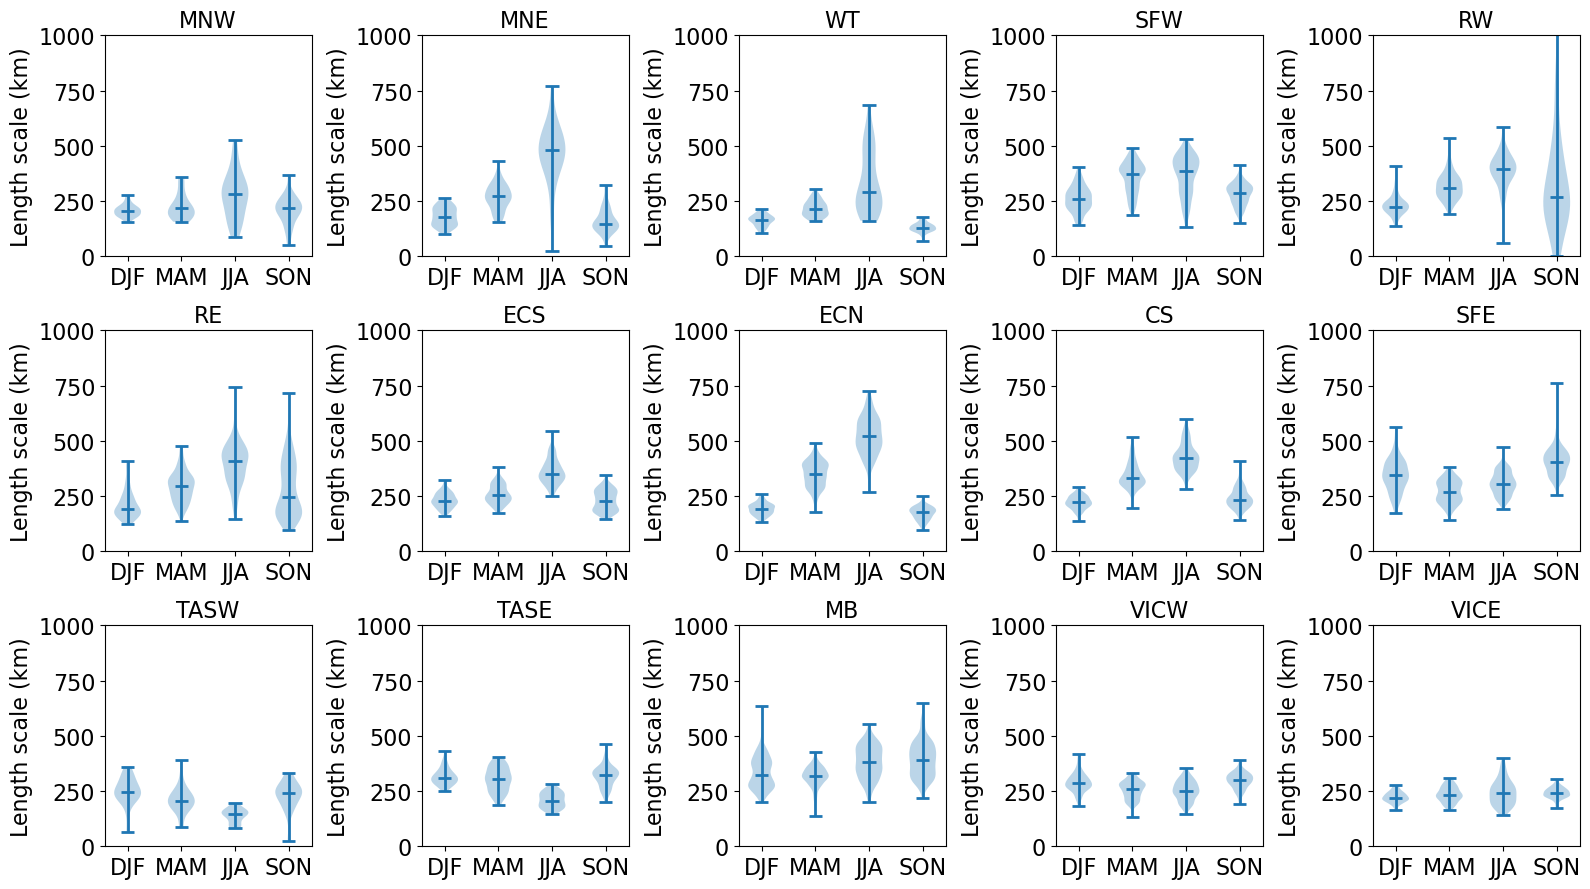

In [25]:
plt.figure(figsize=(16,9))
for i, region in enumerate(["MNW", "MNE", "WT", "SFW", "RW", "RE", "ECS", "ECN", "CS", 
    "SFE", "TASW", "TASE", "MB", "VICW", "VICE"]):
    plt.subplot(3,5,i+1)
    _ = plt.violinplot(nrm_sub_length_dict[region], showmedians=True)
    plt.xticks([1,2,3,4], ["DJF", "MAM", "JJA", "SON"])
    plt.ylabel("Length scale (km)")
    plt.title(region)
    plt.ylim([0,1000])
plt.tight_layout()

In [26]:
df_scale = pd.read_csv("/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_1960/40082_pair_scale_moving_list_all_events.csv")